## Agent Based Modeling (ABM): Apple Trading Model 4

-----------

This material is based on the previous version of CS108L, see https://cs4all.cs.unm.edu/cs108.html
- Credit to Prof. Melanie Moses, Dr. Irene Lee, Dr. Maureen Psaila-Dombrowski, Prof. Dave Ackley and collaborators (see website)

### Computational Science 
- ABM is part of the much broader field of computational science (not computer science!)
- Computational science is the intersection of computer science, mathematices, and science (like biology, or chemistry, or physics)

<img src="https://raw.githubusercontent.com/jbschroder/CS108/main/lecture_images/venn_diagram.png" width="350">

### Computational Science
- Combine math, computer science, and application(s) in the sciences


- We model real world problems to gain insight an knowledge


- This is what we do with ABM
    - We model processes like forest fires and economies that are too big, too complex, too dangerous, or too expensive to conduct in real life
    
    
- Run many "what-if" scenarios quickly, analyze data
    - Computers are always getting faster, so computational science is only getting more important and powerful

### Review: Agent Based Modeling

<img src="https://raw.githubusercontent.com/jbschroder/CS108/main/lecture_images/agent_based_modeling.png" width="300">

### Learning Goals
1. Continue learning about ABM 
    1. How to use ABM
        - Conduct experiments by changing values and variables (like how many apples agents start with, or how combustible a tree is)
        - Collect and analyze results

    2. Learn how to modify ABM
        - Deconstruct models into agents, behaviors, environment, and interactions
     
    3. Learn how to create ABM
        - Implement and evaluate models
        
2. Continue practicing running multiple experiments with different numbers of steps and number of agents
    - Explore possible outcomes
    
    
3. New: allow traders to move on a grid, and only trade with an agent on same square
   - How will this change the speed at which apples trade hands?


### First, we have to make sure that Mesa is installed, and then import our basic packages
- Note that Pandas and Seaborn or "built-in" packages, so we only have to import them, not install them

In [1]:
! pip install mesa==2.1.1


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
%matplotlib inline

import mesa

# Data visualization tools.
import seaborn as sns

# Data manipulation and analysis.
import pandas as pd

### Now, we can begin creating our apple trading agent based model (ABM)

### First, we extend the AppleTraderAgent object, so that the traders can now move!  Freedom!
- Each Step
    - An agent moves to an adjacent square (chosen at random)
    - If that agent has any apples AND  If other agent(s) are on that square, 
        - Then choose one at random, and give them an apple
    
    - Remember that the model step calls each agent step in random order

- The agents are now on a grid (like your turtles), and if two or more agents end up on a square, then they give apples to each other


In [ ]:
# Create ABM

# 1. Define the Agent Abstraction
class AppleTraderAgent(mesa.Agent):
    """An agent that trades apples and begins with 1 apple."""

    def __init__(self, unique_id, model):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        # Create the agent's number of apples and set initial value
        self.NumberApples = 1

    def move(self):
        # define how an agent moves
        # agent moves to randomly chosen surrounding square
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)    
        
    def give_apple(self):
        # define how an agent gives an apple
        
        # find other agents in this cell
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.NumberApples += 1
            self.NumberApples -= 1        
            
    def step(self):
        # move to a neighboring cell and trade apples if someone is there
        self.move()
        if self.NumberApples > 0:
            self.give_apple()               
                
       

### Next, we extend our AppleTradingModel to
1. Randomly place agents on the grid to start
2. Store the spatial locations of the agents for animations in `agent_locations`

### This defines two more of our key abstractions:
1. This defines the environment where the agents (apple traders) exist
2. This also defines how to take a step (tick) forward in time


In [4]:
# 2. Define the Model (or environment) Abstraction for the Agents to live in
class AppleTradingModel(mesa.Model):
    """A model with some number of apple trading agents."""

    def __init__(self, N):
        self.num_agents = N
        
        # Create a spatial grid, 14x14 square grid
        self.grid = mesa.space.MultiGrid(14, 14, True)
        
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)

        # Save the spatial location of the agents in this list
        self.agent_locations = []
        
        # Create agents
        for i in range(self.num_agents):
            a = AppleTraderAgent(i, self)
            # Add the agent to the scheduler
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
    # 3. Define each step or time tick: 
    #    Each step or tick will call the AppleTraderAgent.step() function once
    def step(self):
        """Advance the model by one step."""

        # The model's step will call the step method of each agent
        self.schedule.step()

        # Store spatial locations
        import numpy as np
        agent_counts = np.zeros((self.grid.width, self.grid.height))
        for cell_content, (x, y) in self.grid.coord_iter():
            agent_count = len(cell_content)
            agent_counts[x][y] = agent_count
        self.agent_locations.append(agent_counts)

### The below cell will generate animations.  
- Run this cell, to declare (define) this function
- This function is provided for you.  You only need to know how to use it. It generate animations of your agents as they move around on the grid.

In [5]:
# Run this cell
def plot_agents(model):
    import numpy as np
    import seaborn as sns
    import matplotlib.animation
    import matplotlib.pyplot as plt
    import matplotlib
    
    try:
      # if in a notebook, do inline
      get_ipython().run_line_magic('matplotlib', 'inline')
    except:
      pass

    plt.rcParams['figure.dpi'] = 72
    plt.rcParams["animation.html"] = "jshtml" # javascript html writer
    plt.ioff() # Turn interactive mode off
    plt.rcParams["figure.figsize"] = [7, 7]

    
    fig, ax = plt.subplots()
    global counter 
    counter = 0
    
    def animate(t):
        global counter
        agent_counts = model.agent_locations[t]
        # Plot using seaborn
        if counter == 0:
            g = sns.heatmap(agent_counts, vmin=0, vmax=9, cmap='Set1', cbar=True, square=True, ax=ax)
        else:
            g = sns.heatmap(agent_counts, vmin=0, vmax=9, cmap='Set1', cbar=False, square=True, ax=ax)

        g.figure.set_size_inches(7, 7)
        g.set(title="Number of agents on each cell of the grid")
        counter = counter+1

        
    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(model.agent_locations), interval=200, repeat=False)
    return anim


### Task: In the below cell, create an `AppleTradingModel` with 10 agents.
- Name your model `model`
- Then run that model for 10 steps
- Finally, run the animation cell below.  

### Task: Repeat this.  Observe how the pattern of agent movements changes every time.  
- Try more agents and more steps.  
- Observe how randomness works in practice!

In [ ]:
# Insert Code Here

   

In [7]:
anim = plot_agents(model)
anim

### Task: Run multiple experiments
- Copy/move your code for running multiple experiments into the below cell
- Make sure you track the number of apples for each agent, over all experiments in `all_agents_NumberApples`
- Run the model 100 times for 50 steps. Generate a Seaborn histogram

### Then, copy and paste your cells for running 100 times and plotting with Seaborn so that you  generate plots for
- 25 steps
- 50 steps
- 100 steps
- 200 steps
- 400 steps

You'll need to copy and past 4 times, so that you can generate and see your results for all experiments.

### Make sure to generate a histogram for each set of experiments, i.e., a histogram for 25 steps, then another for 50 steps, and so on.


In [ ]:
%matplotlib inline

all_agents_NumberApples = []

# Insert code here for running multiple experiments


### Lastly, we plot a histogram with Seaborn
- Seaborn provides really sharp plots with little effort
- Pandas also provides histograms, but Seaborn requires less effort

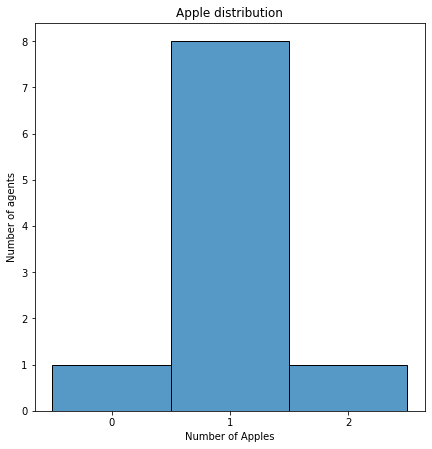

In [11]:
# Use seaborn for plotting
df = pd.DataFrame({'all_agents_NumberApples': all_agents_NumberApples})
ax = sns.histplot(df['all_agents_NumberApples'], discrete=True)
ax.set(title="Apple distribution", xlabel="Number of Apples", ylabel="Number of agents" )

max_apples_owned = df['all_agents_NumberApples'].max() + 1
ax.set_xticks(range(0,max_apples_owned), labels=range(0,max_apples_owned));

Discuss your homework in at least 500 words.  Have sections for 

1. Evidence acquisition 
     - Describe the experiments you conducted. Give all the details, number of agents, steps, abstractions used, and so on. 
     - You are describing application of a quantitative model (the agent based model)

2. Evidence evaluation 
    - Discuss your plots and any other results.  What did you find? 
    - You are communicating and representing quantitative information
    
3. Conclusion
    - What can you conclude?  
    - What is still unexplained? 
    - You've compared two models (one where agents can move, and one where they cannot).  
        - Does this tell you anything how trading in the real world might work?  
        - What details are missing in the model that you think are most needed?


For this homework, pay attention to these questions.
- Compare the cases where agents cannot move in space versus when they can move in space
    - That is, compare the results from the last lab, to this lab
- What was the effect of allowing for movement, and restricting trading to be only between agents on the same square?
    - Did the speed at which apples were traded change?

### Homework Discussion Goes here

### Homework Submission Instructions

### The homework submission instructions are different this week. 

### Download your notebook as an ".ipynb" file, and upload the ipynb file as your assignment to Canvas.

### Do not upload a .py file